In [1]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
df = pd.read_csv('quakes.csv')

# Misión 0

In [3]:
df.head()

,ID,Lat,Long,Depth,Mag,Stations
0,1,-20.42,181.62,562.0,4.8,41.0
1,2,-20.62,181.03,650.0,4.2,15.0
2,3,-26.00,184.10,42.0,5.4,43.0
3,4,-17.97,181.66,626.0,4.1,19.0
4,5,-20.42,181.96,649.0,4.0,11.0


In [4]:
df.describe()

,ID,Lat,Long,Depth,Mag,Stations
count,1000.000000,999.000000,995.000000,996.000000,996.000000,987.000000
mean,500.500000,-20.647538,179.470854,310.668675,6.840261,36.829787
std,288.819436,5.029029,6.059105,215.060063,11.990329,32.775427
min,1.000000,-38.590000,165.670000,40.000000,4.000000,10.000000
25%,250.750000,-23.470000,179.645000,99.000000,4.300000,18.000000
50%,500.500000,-20.300000,181.410000,246.000000,4.600000,27.000000
75%,750.250000,-17.640000,183.165000,541.250000,4.900000,43.000000
max,1000.000000,-10.720000,188.130000,680.000000,85.000000,280.000000


# Misión *1*

Primero analizaremos la distribución de los datos, esto será útil para identificar los valores extremos, las columnas ID, Lat y Long no son tan directas de analizar, debido a que el ID es solo un identificador y las coordenadas de latitud y longitud podrían darse en valores alejados por islas o cosas por el estilo. Por esto el análisis se centrará en las tres restantes. Primero se realizará un histograma junto con un boxplot para ver la distribución de valores.

De todas formas para entender mejor la distribución espacial de los sismos registrados se presenta el siguiente gráfico.

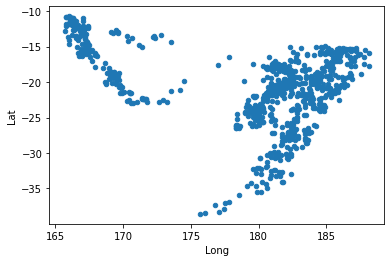

In [5]:
df.plot.scatter("Long","Lat")

A simple vista no se ven puntos demasiado aislados del resto, y al revisar las coordenadas se puede notar que son en el oceano

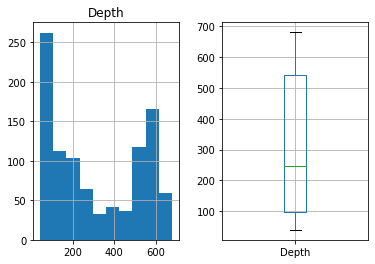

In [6]:
fig, axs = plt.subplots(1,2)
df.hist("Depth",ax=axs[0])
df.boxplot("Depth",ax=axs[1])

A simple vista no se ven valores extremos, sino más bien dos clusters que se separa en el valor 350-400. Por lo que no tomaremos acciones en esta columna

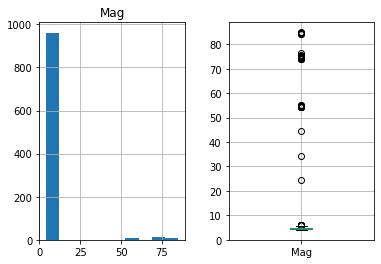

In [7]:
fig, axs = plt.subplots(1,2)
df.hist("Mag",ax=axs[0])
df.boxplot("Mag",ax=axs[1])

A diferencia del caso anterior, se pueden notar valores muy alejados de la mayoría, para analizar mejor realizaremos un histograma y boxplot de los valores menores a 15.

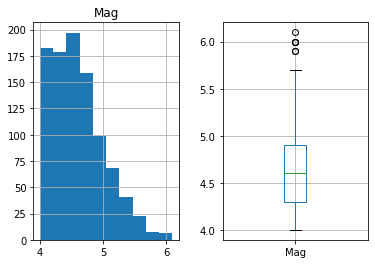

In [8]:
fig, axs = plt.subplots(1,2)
df[df["Mag"]<15].hist("Mag",ax=axs[0])
df[df["Mag"]<15].boxplot("Mag",ax=axs[1])

Ahora si es posible ver una distribución más clara, probablemente los datos superiores a 15 se deben a errores, dado que la gran mayoría de los datos se encuentra entre 4 y 6. Analizaremos de todas formas la proporción de datos que corresponden a valores extremos

In [9]:
len(df[df["Mag"]<15])/len(df)

0.961

Podemos notar que menos del 5% de los datos son superiores a 15, por lo que eliminarlos es una buena alternativa.

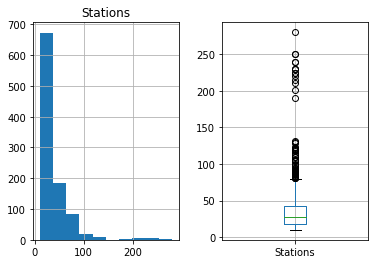

In [10]:
fig, axs = plt.subplots(1,2)
df.hist("Stations",ax=axs[0])
df.boxplot("Stations",ax=axs[1])

In [11]:
len(df[df["Stations"]<150])/len(df)

0.972

En este caso se notan valores extremos, pero la distribución de datos pareciera ser exponencial, por lo que es lógico que existan valores extremos. En este caso se pueden eliminar los valores superiores a 150 o simplemente dejarlo así como está. Otra opción es utilizar el logaritmo de la columna, lo cual hará que los valores extremos no afecten tanto a la distribución de datos. Veamos como queda esto:

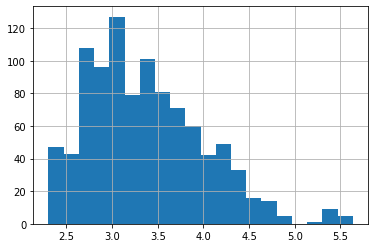

In [12]:
df['Stations_log'] = np.log(df['Stations'])
df['Stations_log'].hist(bins=20)
plt.show()

Como podemos ver, ahora los datos adoptan una distribución donde afectan menos los valores extremos por lo que se va a usar el logaritmo de stations en lo que sigue.

# Valores faltantes

In [13]:
df.apply(lambda x: sum(x.isnull()),axis=0)

ID               0
Lat              1
Long             5
Depth            4
Mag              4
Stations        13
Stations_log    13
dtype: int64

Aquellas columnas con valores nulos en LAT y LONG, van a ser eliminadas, pues resulta muy difícil predecir la ubicación de un temblor, aun teniendo los otros datos. Además, reemplazar por algo como el promedio, haría que muchos temblores se sitúen en esta coordenada, cuando en realidad es difícil que varios temblores se produzcan en exactamente el mismo lugar y esto podría producir una tendencia extraña al analizar los datos. Considerando que es solo 1 columna para LAT y 5 para LONG, no se perdería una cantidad de información muy importante.

Acá se puede optar por hacer cosas distintas con los nulos, lo cual puede estar correcto siempre que se justifique con buenos argumentos.

In [14]:
df = df.dropna(subset=['Lat', 'Long'])
df = df.reset_index(drop=True) #Reseteamos los índices pues ahora hay menos columnas (recordar que indice != ID)

In [15]:
df.apply(lambda x: sum(x.isnull()),axis=0)

ID               0
Lat              0
Long             0
Depth            4
Mag              4
Stations        13
Stations_log    13
dtype: int64

Con la columna Mag, podemos notar en describe que el max es 85 y el promedio es 6,84. Resulta casi imposible que haya un terremoto magnitud 85 (pues la escala es exponencial), por lo que todas las columnas con valores mayores a 15 serán eliminadas

In [16]:
df = df.drop(df[df.Mag > 15].index)
df = df.reset_index(drop=True) #Reseteamos los índices

In [17]:
df.describe()

,ID,Lat,Long,Depth,Mag,Stations,Stations_log
count,959.000000,959.000000,959.000000,955.000000,955.000000,946.000000,946.000000
mean,511.176225,-20.640094,179.550584,312.672251,4.622304,37.065539,3.376308
std,285.702923,4.969243,6.012048,215.394530,0.401145,33.133623,0.641144
min,1.000000,-38.590000,165.670000,40.000000,4.000000,10.000000,2.302585
25%,268.500000,-23.460000,179.780000,100.000000,4.300000,18.000000,2.890372
50%,516.000000,-20.300000,181.440000,248.000000,4.600000,27.000000,3.295837
75%,757.500000,-17.675000,183.200000,543.000000,4.900000,43.000000,3.761200
max,1000.000000,-10.720000,188.130000,680.000000,6.100000,280.000000,5.634790


Ahora podemos notar que el promedio de Mag bajó y el nuevo valor máximo es 6,1.

Para las otras columnas que quedan con valores nulos, tenemos a Mag y Stations_log. En el caso de stations, podemos notar que el promedio es una buena representación luego de haber aplicado logaritmo, pues este se sitúa en un lugar medio de los datos y no es afectado por los valores extremos:

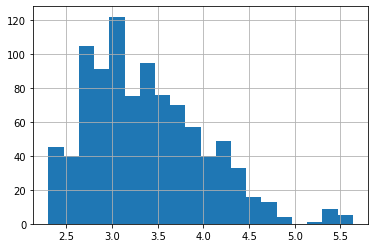

El promedio es:3.376308494199311


In [18]:
df['Stations_log'] = np.log(df['Stations'])
df['Stations_log'].hist(bins=20)
plt.show()
print("El promedio es:" + str(df['Stations_log'].mean()))

Viendo esto, vamos a reemplazar los valores nulos de stations_log por el promedio de la columna. 

En caso de no tomar el logaritmo, y usar la columna "stations" original, también sería válido haber generado datos según una exponencial, pues, como se mostró en el histograma arriba, esta columna sin logaritmo adapta una forma similar a la de la distribución exponencial.

In [19]:
df['{}'.format('Stations_log')].fillna(df['{}'.format('Stations_log')].mean(), inplace=True)

Para Mag, como pudimos ver más arriba los datos se dividían en 2 clusters aproximadamente, por lo que vamos a rellenar los datos faltantes según esto. Vamos a dividir los clusters a partir del 350.

In [20]:
cluster1 = df[df['Depth'] <= 350]
cluster2 = df[df['Depth'] > 350]

Ahora vamos a calcular la proporción de datos que forman parte de cada cluster. Luego de esto, vamos a ir reemplazando los datos faltantes según el promedio de cada cluster, con una probabilidad según la proporción de datos que cada cluster tiene.

In [21]:
proporcion2 = cluster2.shape[0]/(cluster2.shape[0] + cluster1.shape[0])
proporcion1 = 1 - proporcion2
print(f"Cluster 1: {proporcion1}, cluster 2: {proporcion2}")
proporciones = [proporcion1, proporcion2]

Cluster 1: 0.5717277486910994, cluster 2: 0.4282722513089005


In [29]:
promedio_c1 = cluster1['Depth'].mean()
promedio_c2 = cluster2['Depth'].mean()
df['{}'.format('Depth')].fillna(random.choices([promedio_c1, promedio_c2], [proporcion1, proporcion2])[0], inplace=True)

Finalmente, para Mag, los datos son bastante uniformes (luego de haber removido los datos extremos), por lo que se va a reemplazar los valores faltantes por el promedio de la columna.

In [ ]:
for k in ['Mag']:
    df['{}'.format(k)].fillna(df['{}'.format(k)].mean(), inplace=True)

In [31]:
df.apply(lambda x: sum(x.isnull()),axis=0)

ID               0
Lat              0
Long             0
Depth            0
Mag              4
Stations        13
Stations_log     0
dtype: int64

# Misión 2

Para lo que viene, vamos a borrar la columna stations y renombrar "stations_log" a "stations"

Primero vamos a mostrar el promedio, desviación estandar, máximo y mínimo para cada columna:

In [33]:
df = df.drop('Stations', 1)
df = df.rename(columns={'Stations_log': 'Stations'})

In [34]:
df_stats = df.describe().loc[['mean', 'std', 'min', 'max']]
df_stats

,ID,Lat,Long,Depth,Mag,Stations
mean,511.176225,-20.640094,179.550584,313.638611,4.622304,3.376308
std,285.702923,4.969243,6.012048,215.462938,0.401145,0.636779
min,1.000000,-38.590000,165.670000,40.000000,4.000000,2.302585
max,1000.000000,-10.720000,188.130000,680.000000,6.100000,5.634790


Ahora la kurtosis:

In [ ]:
kurt = df_stats.kurtosis()

In [ ]:
df_stats.loc['kurtosis'] = kurt

Finalmente, hacemos la correlacion y la agregamos a la tabla

In [ ]:
df_stats.loc['correlacion_mag'] = df_stats.corr()['Mag']

Mostramos la tabla:

In [ ]:
df_stats

,ID,Lat,Long,Depth,Mag,Stations
mean,510.087958,-20.653309,179.547717,312.672251,4.622713,37.142251
std,285.670774,4.973498,6.010727,215.394530,0.400981,32.953543
min,1.000000,-38.590000,165.670000,40.000000,4.000000,10.000000
max,1000.000000,-10.720000,188.130000,680.000000,6.100000,280.000000
kurtosis,0.468245,0.112977,3.765963,1.484099,2.062625,3.835982
correlacion_mag,0.644631,-0.578829,0.923630,0.637524,1.000000,0.662167


# Misión 3

Vamos a hacer un heatmap, con la librería seaborn

In [ ]:
import seaborn as sns
df_heatmap = df[['Lat', 'Long', 'Mag']]
df_heatmap.reset_index()
df_heatmap

,Lat,Long,Mag
0,-20.42,181.62,4.8
1,-20.62,181.03,4.2
2,-26.00,184.10,5.4
3,-17.97,181.66,4.1
4,-20.42,181.96,4.0
...,...,...,...
950,-17.95,181.37,4.0
951,-17.70,188.10,4.2
952,-25.93,179.54,4.4
953,-12.28,167.06,4.7


Desplegamos el heatmap:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


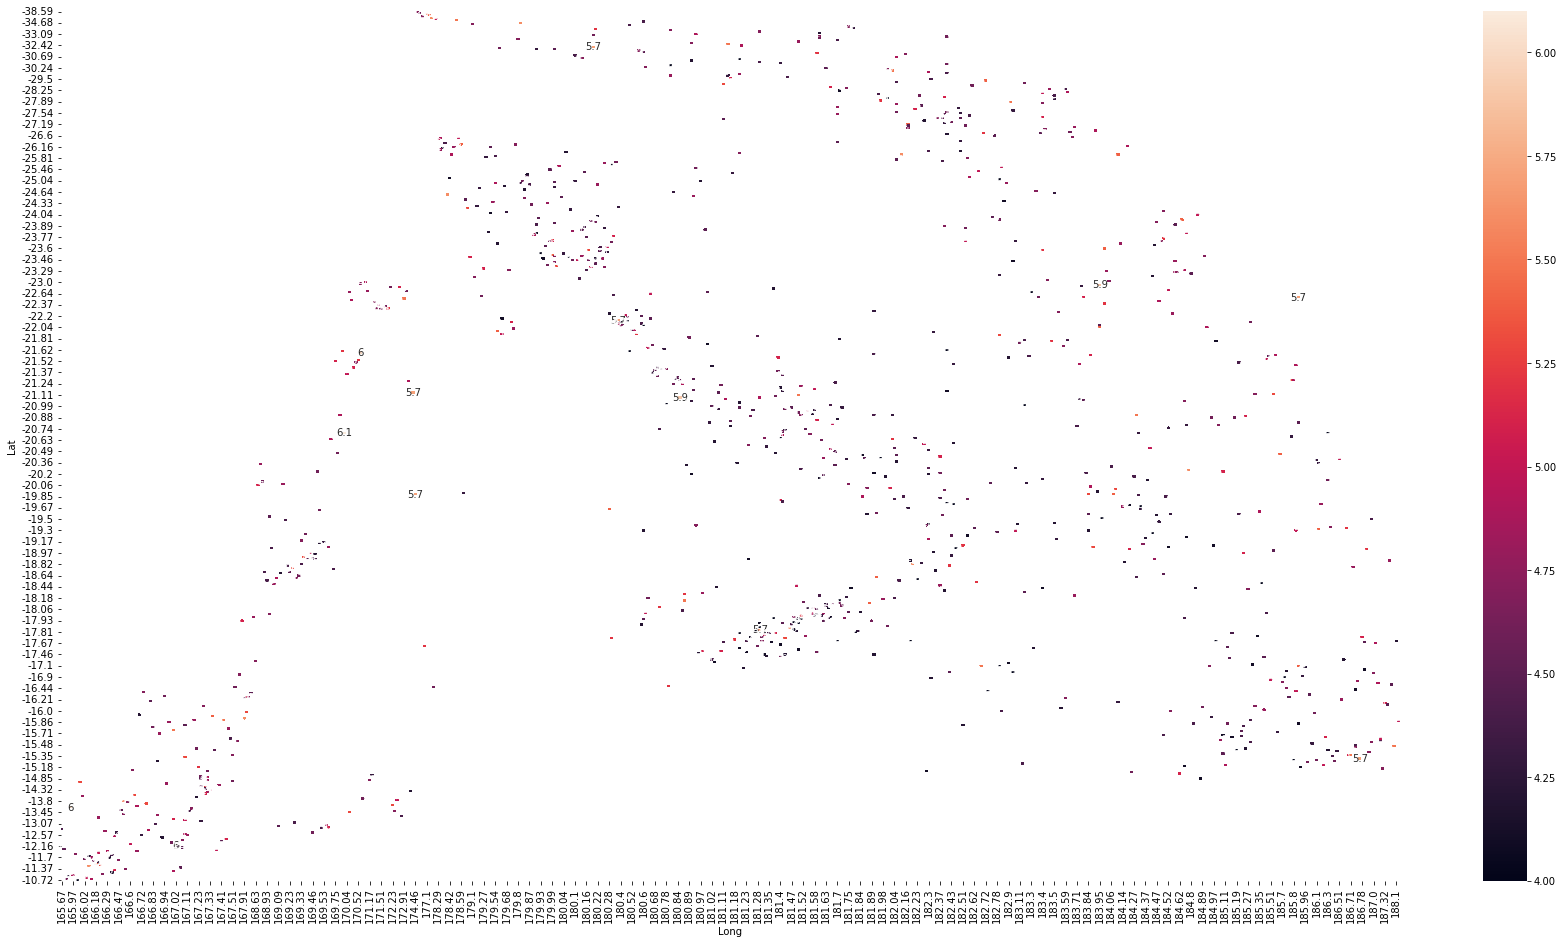

In [ ]:
import matplotlib.pyplot as plt


df = df_heatmap
df.drop_duplicates(['Lat','Long'], inplace=True)
pivot = df.pivot(index='Lat', columns='Long', values='Mag')
plt.figure(figsize = (30,16))
ax = sns.heatmap(pivot,annot=True)